## import modules

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import requests
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import os
import matplotlib.pyplot as plt
import numpy as np

## define model architecture

In [99]:
class ConvNet(nn.Module):
    def __init__(self):
       super(ConvNet, self).__init__()
       self.conv1 = nn.Conv2d(3, 6, 5)
       self.pool = nn.MaxPool2d(2, 2)
       self.conv2 = nn.Conv2d(6, 16, 5)
       self.fc1 = nn.Linear(16 * 5 * 5, 120)
       self.fc2 = nn.Linear(120, 84)
       self.fc3 = nn.Linear(84, 10)
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [100]:
# https://www.kaggle.com/anindya2906/cifar10-raw-images
classes = ('Airplane', 'Automobile', 'Bird', 'Cat',
           'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
list_urls = {"train": [], "test": []}
list_labels = {"train": [], "test": []}

create_tensor = transforms.ToTensor()

for env in ["train", "test"]:
    index = -1
    for _class in classes:
        index = index + 1
        directory = os.fsencode(os.path.abspath('./data/cifar10_raw/images/'+env+'/'+ _class))
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".png"): 
                url = os.path.join(directory, filename.encode('ascii'))
                img = Image.open(url)
                img_tensor = create_tensor(img)
                new_url = url+ '.pt'.encode('ascii')
                if(not os.path.exists(new_url)):
                    torch.save(img_tensor, new_url.decode('ascii') )

                list_urls[env].append(new_url)
                list_labels[env].append(index)
                continue
            else:
                continue


In [101]:

class DatasetByUrls(torch.utils.data.Dataset):  
    # https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
    # https://www.kaggle.com/anindya2906/cifar10-raw-images
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_URLs, labels, transform=None, percent = 1.0):
        #super().__init__()
        'Initialization'
        self.labels = labels
        self.list_URLs = list_URLs
        self.indexes = list(range(len(self.list_URLs)))
        random.shuffle(self.indexes)
        self.transform = transform
        self.num_classes = len(set(labels))

  def __len__(self):
        'Denotes the total number of samples'
        count = int(percent*len(self.list_URLs))
        return count

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #print(" %d  / %d " % (index, len(self.indexes)))
        ID = self.indexes[index]

        # Load data and get label
        url =  self.list_URLs[ID]
        
        X = torch.load(url.decode('ascii') ) # Image.open(url)
        if self.transform is not None:
            X = self.transform(X)

        y = self.labels[ID]
        return X, y

## define training and inference routines

In [102]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## define optimizer and run training epochs

In [103]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = criterion(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 100 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))


In [104]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += criterion(pred_prob, y)  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))


## create data loaders

In [105]:
transform = transforms.Compose([ transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

percent = 1.0
num_workers = 0
trainset = DatasetByUrls(list_urls['train'], list_labels['train'], transform=transform, percent = percent)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True, num_workers=num_workers)

testset = DatasetByUrls(list_urls['train'], list_labels['train'], transform=transform,  percent = percent)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False, num_workers= num_workers)


In [106]:
for epoch in range(1, 100):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

epoch: 1 [0/100 (0%)]	 training loss: 2.319892

Test dataset: Overall Loss: 0.4601, Overall Accuracy: 12/100 (12%)

epoch: 2 [0/100 (0%)]	 training loss: 2.324684

Test dataset: Overall Loss: 0.4593, Overall Accuracy: 12/100 (12%)

epoch: 3 [0/100 (0%)]	 training loss: 2.310220

Test dataset: Overall Loss: 0.4582, Overall Accuracy: 18/100 (18%)

epoch: 4 [0/100 (0%)]	 training loss: 2.306191

Test dataset: Overall Loss: 0.4562, Overall Accuracy: 21/100 (21%)

epoch: 5 [0/100 (0%)]	 training loss: 2.284666

Test dataset: Overall Loss: 0.4524, Overall Accuracy: 28/100 (28%)

epoch: 6 [0/100 (0%)]	 training loss: 2.238560

Test dataset: Overall Loss: 0.4435, Overall Accuracy: 31/100 (31%)

epoch: 7 [0/100 (0%)]	 training loss: 2.224179

Test dataset: Overall Loss: 0.4098, Overall Accuracy: 22/100 (22%)

epoch: 8 [0/100 (0%)]	 training loss: 1.982771

Test dataset: Overall Loss: 0.4215, Overall Accuracy: 18/100 (18%)

epoch: 9 [0/100 (0%)]	 training loss: 1.956338

Test dataset: Overall Lo

## run inference on trained model

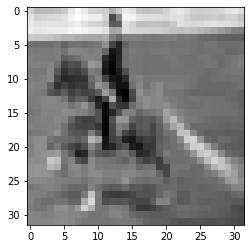

In [107]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [108]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 7
Ground truth is : 7
